# 🌍 Character-Level Language Classification with RNN

Welcome! 👋  
In this notebook, we will build a character-level Recurrent Neural Network (RNN) that learns to classify the **language of a surname**. This is a hands-on project based on PyTorch's official tutorial, designed to teach:

---

## 🎯 Objectives
By the end of this notebook, you will be able to:
- Load and preprocess multilingual text data.
- Convert names into tensor representations suitable for neural networks.
- Build and train a character-level RNN using PyTorch.
- Evaluate your model’s performance using accuracy and a confusion matrix.
- Make predictions on new, unseen surnames.

---

## 🧠 What You Will Learn
- How to normalize Unicode text for model compatibility.
- How to work with variable-length sequences in PyTorch.
- How to design a simple RNN for sequence classification.
- How to evaluate classification models both quantitatively and visually.
- How to run custom inference for real-world inputs.

---

## 📂 Dataset Description
The dataset consists of several text files, each named after a language (e.g., `Arabic.txt`, `English.txt`, etc.). Each file contains a list of surnames commonly associated with that language.

- ✅ **Input**: A surname (e.g., `"Haddad"`)
- 🎯 **Goal**: Predict the correct language label (e.g., `"Arabic"`)

---

## 🧭 Notebook Structure
This notebook is organized into the following steps:

1. **Dataset Download and Setup**
2. **Text Normalization & Preprocessing**
3. **Custom PyTorch Dataset Definition**
4. **Character-Level RNN Model**
5. **Model Training with Accuracy Tracking**
6. **Model Evaluation & Visualization**
7. **Real-Time Inference on User Input**

---

Let’s dive in! 🔥


### 📥 Step 1: Download and Unzip the Dataset
This cell downloads a zip file containing the names dataset provided by PyTorch's official tutorials.
The dataset includes multiple `.txt` files, each named after a language and containing a list of surnames from that language.


In [ ]:
!wget -q https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip

### 🧰 Step 2: Import Required Libraries
We import essential Python libraries:
- `string`, `unicodedata`, and `os` for text and file processing.
- `torch`, `nn`, and `Dataset` for model building and data handling.
- `matplotlib` for visualizing results like training loss and confusion matrix.


In [ ]:
import string
import unicodedata
from io import open
import glob
import os
import time
import random
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### 🔤 Step 3: Normalize Unicode Text to ASCII
Many names may contain accented characters (e.g., "José", "René").
To simplify the model’s input, we define a function that converts these to plain ASCII ("Jose", "Rene").
We also define a set of allowed characters and represent out-of-vocabulary characters using "_".


We convert Unicode to ASCII to:
- Keep character vocabulary small and efficient
- Remove accents/symbols that may confuse the model
- Prevent errors from unseen Unicode at inference time
- Ensure consistent inputs (e.g., é → e)
- Simplify training and improve generalization


In [ ]:
# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
#String of allowed chars
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# So, this function basiclly takes unicode word (ex; Café ) and convert it to (Cafe)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [ ]:
#Example of how it works
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


### 🔢 Step 4: Convert Character to Index
This function maps each character to its index in the allowed character list.
If a character is not in the list (e.g., emoji or symbol), it is mapped to the "_" index.
This index is used to create one-hot vectors later.


In [ ]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

### 📐 Step 5: Convert Full Name to Tensor
This function converts an entire name (e.g., "Ali") into a 3D tensor:
- Shape: `(sequence_length, 1, n_letters)`
- Each character is represented as a one-hot encoded vector across the allowed character set.


In [ ]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [ ]:
print (f"The letter 'a' becomes {lineToTensor('_')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes :\n{lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 1.]]])
The name 'Ahn' becomes :
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

### 📦 Step 6: Create a Custom Dataset Class
We create a PyTorch-compatible `Dataset` that:
- Loads all `.txt` files in the `data/names/` folder.
- Converts each name into a tensor and assigns it a label based on the filename.
- Stores both the raw text and its tensor representation.
This allows us to easily use this dataset with PyTorch's training pipeline.


In [ ]:
class NamesDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for raw_name in lines:
              name = unicodeToAscii(raw_name.strip())
              self.data.append(name)
              self.data_tensors.append(lineToTensor(name))
              self.labels.append(label)


        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

### 🧪 Step 7: Load the Dataset and Inspect
We create an instance of our `NamesDataset` and print out one example to verify that:
- The data is loaded correctly.
- Each name has been converted to a tensor.
- The label is correctly associated.


In [ ]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([14]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]]), 'Korean', 'Ahn')


### 🔀 Step 8: Split Dataset into Training and Validation Sets
To evaluate generalization, we split the dataset:
- 85% for training
- 15% for validation/testing
We ensure reproducibility using a seeded random generator and make the generator device-aware (e.g., CUDA vs CPU).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device='cpu').manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


### 🧠 Step 9: Define the CharRNN Model
We define a character-level RNN model with the following components:
- An `nn.RNN` layer that processes character sequences.
- A fully connected layer to project hidden states to class scores.
- A `LogSoftmax` layer to get log-probabilities over the possible languages.


In [ ]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

### 🏗️ Step 10: Instantiate the Model
We initialize the `CharRNN` model with:
- Input size equal to number of characters (`n_letters`)
- Hidden size (e.g., 128)
- Output size equal to the number of languages/classes in the dataset


In [ ]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq)).to(device)
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


### 🔍 Step 11: Quick Test on a Sample Name
We run a forward pass on a sample name (e.g., "Albert") to:
- Check the shape and content of model output.
- Verify the predicted language label using `label_from_output`, which returns the most likely class.


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input.to(device)) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.8832, -2.9620, -2.9486, -2.8019, -2.9151, -2.9137, -2.9707, -2.9234,
         -2.8520, -2.8547, -2.9238, -2.9476, -2.9429, -2.9403, -2.8356, -2.8091,
         -2.7704, -2.8629]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Arabic', 16)


### 🏋️ Step 12: Train the Model with Accuracy and Progress Tracking
We define a training loop that:
- Uses manual batching to handle variable-length input names.
- Uses SGD for optimization and clips gradients to prevent exploding gradients.
- Tracks training and test loss + accuracy for every epoch.
- Adds a `tqdm` progress bar for better visibility during training.
- Evaluates on the test set after each epoch for clear learning feedback.


In [ ]:
from tqdm import tqdm

def train(rnn, training_data, testing_data, n_epoch=10, n_batch_size=64, learning_rate=0.2, criterion=nn.NLLLoss()):
    """
    Train the CharRNN and report train/test loss and accuracy per epoch.
    """
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(1, n_epoch + 1):
        rnn.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        # Shuffle and batch training data manually
        indices = list(range(len(training_data)))
        random.shuffle(indices)
        batches = np.array_split(indices, len(indices) // n_batch_size)

        for batch in tqdm(batches, desc=f"Epoch {epoch}/{n_epoch}", leave=False):
            batch_loss = 0
            batch_correct = 0

            optimizer.zero_grad()
            for i in batch:
                label_tensor, text_tensor, label, text = training_data[i]
                output = rnn(text_tensor.to(device))
                loss = criterion(output.to(device), label_tensor.to(device))
                batch_loss += loss

                # Accuracy calculation
                pred_label, _ = label_from_output(output, alldata.labels_uniq)
                if pred_label == label:
                    batch_correct += 1

            # Backpropagation
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()

            avg_loss = batch_loss.item() / len(batch)
            total_train_loss += avg_loss
            correct_train += batch_correct
            total_train += len(batch)

        train_losses.append(total_train_loss / len(batches))
        train_accuracies.append(correct_train / total_train)

        # --- Evaluation ---
        rnn.eval()
        total_test_loss = 0
        correct_test = 0
        with torch.no_grad():
            for i in range(len(testing_data)):
                label_tensor, text_tensor, label, text = testing_data[i]
                output = rnn(text_tensor.to(device))
                loss = criterion(output.to(device), label_tensor.to(device))
                total_test_loss += loss.item()

                pred_label, _ = label_from_output(output, alldata.labels_uniq)
                if pred_label == label:
                    correct_test += 1

        test_losses.append(total_test_loss / len(testing_data))
        test_accuracies.append(correct_test / len(testing_data))

        print(f"\nEpoch {epoch}/{n_epoch}")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Accuracy: {train_accuracies[-1]*100:.2f}%")
        print(f"  Test  Loss: {test_losses[-1]:.4f}, Accuracy: {test_accuracies[-1]*100:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies


### ⏱️ Step 13: Run Training and Measure Time
We call the training function for a fixed number of epochs and measure how long it takes.
After training, we retrieve lists of training/test loss and accuracy for plotting and evaluation.


In [ ]:
start = time.time()
train_losses, test_losses, train_accs, test_accs = train(rnn, train_set, test_set, n_epoch=7, learning_rate=0.15)
end = time.time()
print(f"Training took {end - start:.2f}s")



Epoch 1/7
  Train Loss: 1.4032, Accuracy: 57.77%
  Test  Loss: 1.1474, Accuracy: 65.83%



Epoch 2/7
  Train Loss: 1.0957, Accuracy: 66.47%
  Test  Loss: 1.1107, Accuracy: 66.39%



Epoch 3/7
  Train Loss: 1.0040, Accuracy: 69.41%
  Test  Loss: 1.0099, Accuracy: 68.62%



Epoch 4/7
  Train Loss: 0.9399, Accuracy: 71.00%
  Test  Loss: 0.9371, Accuracy: 70.18%



Epoch 5/7
  Train Loss: 0.8876, Accuracy: 72.60%
  Test  Loss: 0.8718, Accuracy: 74.76%



Epoch 6/7
  Train Loss: 0.8335, Accuracy: 74.24%
  Test  Loss: 0.9103, Accuracy: 70.84%



Epoch 7/7
  Train Loss: 0.7859, Accuracy: 75.81%
  Test  Loss: 0.8043, Accuracy: 75.19%
Training took 138.53s


### 📈 Step 14: Plot Loss Over Epochs
We plot the test Loss over training epochs to visually monitor the model’s performance.



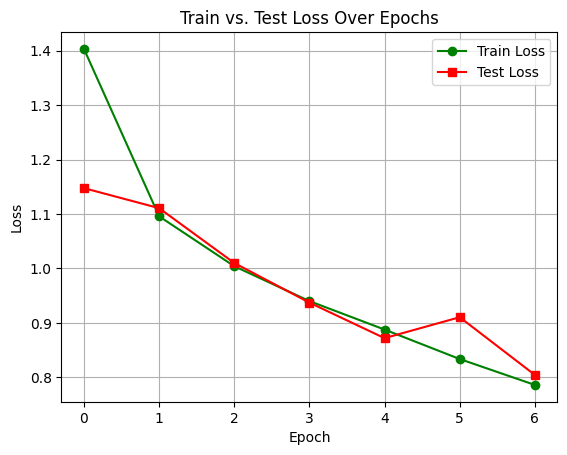

In [ ]:
# ✅ Plot training and test loss over epochs
plt.figure()
plt.plot(train_losses, label='Train Loss', color='green', marker='o')
plt.plot(test_losses, label='Test Loss', color='red', marker='s')
plt.title('Train vs. Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


### 📈 Step 15: Plot Accuracy Over Epochs
We plot the test accuracy over training epochs to visually monitor the model’s performance.
Accuracy values range from 0 to 1 (i.e., 0% to 100%).


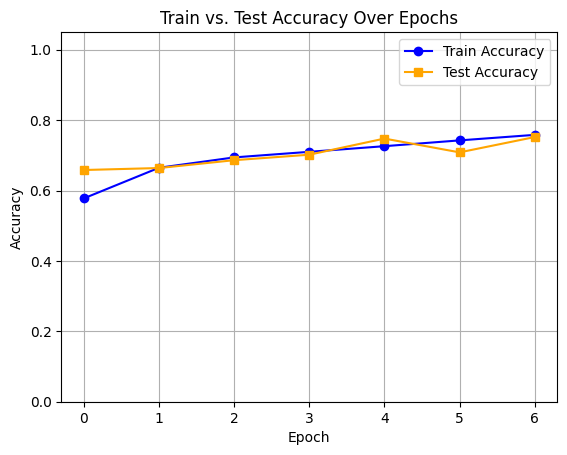

In [ ]:
# ✅ Plot training and test accuracy over epochs
plt.figure()
plt.plot(train_accs, label='Train Accuracy', color='blue', marker='o')
plt.plot(test_accs, label='Test Accuracy', color='orange', marker='s')
plt.title('Train vs. Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()


### 📊 Step 16: Evaluate Model with Confusion Matrix
We evaluate the model on the test set and build a confusion matrix to:
- Visualize how often the model confuses one language with another.
- Normalize each row so values represent percentages.
- Highlight patterns or biases in classification performance.


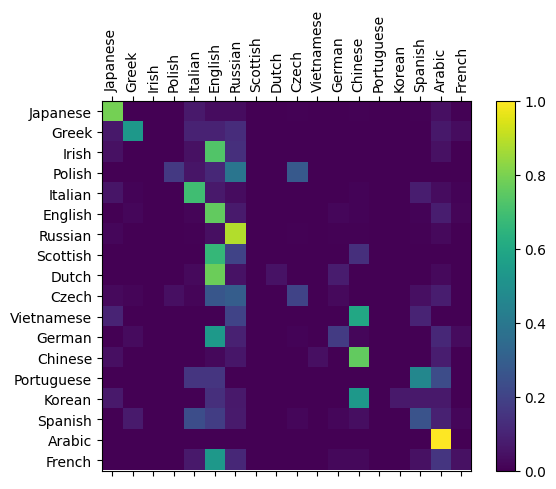

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor.to(device))
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)

### ✨ Step 16: Predict Language of a Custom Surname
This cell allows you to test the trained model on a custom surname (e.g., "Haddad").
It:
- Converts the name to a tensor.
- Passes it through the trained model.
- Prints the predicted language along with a confidence score.
You can replace the `test_name` value to try different names.


In [ ]:
# ✅ Inference function to predict the language of a given name
def predict_language(rnn, name, label_list):
    rnn.eval()
    with torch.no_grad():
        name_ascii = unicodeToAscii(name.strip())
        tensor = lineToTensor(name_ascii)
        output = rnn(tensor.to(device))
        predicted_label, confidence_idx = label_from_output(output, label_list)
        confidence = torch.exp(output[0][confidence_idx]).item()
        return predicted_label, confidence

# --- Run inference on a static example ---
test_name = "Haddad"
predicted_lang, conf = predict_language(rnn, test_name, alldata.labels_uniq)
print(f"Surname: {test_name}")
print(f"Predicted Language: {predicted_lang}")
print(f"Confidence: {conf:.2f}")


Surname: Haddad
Predicted Language: Arabic
Confidence: 0.99


##Contirbuted by: Yazan Alshoibi